# Fake news detection using ML(Naive Bayes, Decision Tree,Logistic Regression,Random Forest,SVM) **************************************************************************

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [6]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [7]:
fake.shape

(23481, 4)

In [8]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [9]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [10]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [11]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [12]:
# Check the data
data.head()

,title,text,subject,date,target
0,"FOX News MOCKS MSNBC’s Chris Matthews, Who Act...",MSNBC s Chris Matthews deemed the big story ...,left-news,"Jul 9, 2017",fake
1,Finland plans military drill with United State...,HELSINKI (Reuters) - Finland is planning large...,worldnews,"November 3, 2017",true
2,"If You’re Looking For Ways To Irritate Trump,...",It s been a well-known fact for quite some tim...,News,"October 28, 2017",fake
3,"Putin, in telegram to Syria's Assad, hails 'st...",MOSCOW (Reuters) - Russian President Vladimir ...,worldnews,"September 5, 2017",true
4,"White House Gives Up Trying To Control Trump,...","Ever since his presidential campaign, Donald T...",News,"June 18, 2017",fake


In [13]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,"FOX News MOCKS MSNBC’s Chris Matthews, Who Act...",MSNBC s Chris Matthews deemed the big story ...,left-news,fake
1,Finland plans military drill with United State...,HELSINKI (Reuters) - Finland is planning large...,worldnews,true
2,"If You’re Looking For Ways To Irritate Trump,...",It s been a well-known fact for quite some tim...,News,fake
3,"Putin, in telegram to Syria's Assad, hails 'st...",MOSCOW (Reuters) - Russian President Vladimir ...,worldnews,true
4,"White House Gives Up Trying To Control Trump,...","Ever since his presidential campaign, Donald T...",News,fake


In [14]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,MSNBC s Chris Matthews deemed the big story ...,left-news,fake
1,HELSINKI (Reuters) - Finland is planning large...,worldnews,true
2,It s been a well-known fact for quite some tim...,News,fake
3,MOSCOW (Reuters) - Russian President Vladimir ...,worldnews,true
4,"Ever since his presidential campaign, Donald T...",News,fake


In [15]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,msnbc s chris matthews deemed the big story ...,left-news,fake
1,helsinki (reuters) - finland is planning large...,worldnews,true
2,it s been a well-known fact for quite some tim...,News,fake
3,moscow (reuters) - russian president vladimir ...,worldnews,true
4,"ever since his presidential campaign, donald t...",News,fake


In [16]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [17]:
# Check
data.head()

,text,subject,target
0,msnbc s chris matthews deemed the big story ...,left-news,fake
1,helsinki reuters finland is planning largesca...,worldnews,true
2,it s been a wellknown fact for quite some time...,News,fake
3,moscow reuters russian president vladimir put...,worldnews,true
4,ever since his presidential campaign donald tr...,News,fake


In [18]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
data.head()

,text,subject,target
0,msnbc chris matthews deemed big story much ant...,left-news,fake
1,helsinki reuters finland planning largescale m...,worldnews,true
2,wellknown fact quite time donald trump handle ...,News,fake
3,moscow reuters russian president vladimir puti...,worldnews,true
4,ever since presidential campaign donald trump ...,News,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


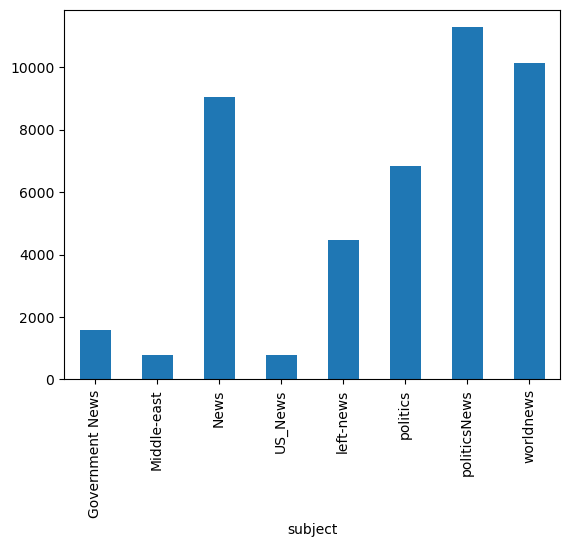

In [20]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


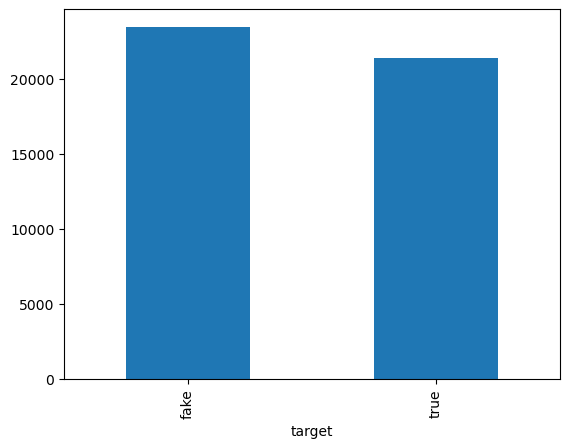

In [21]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

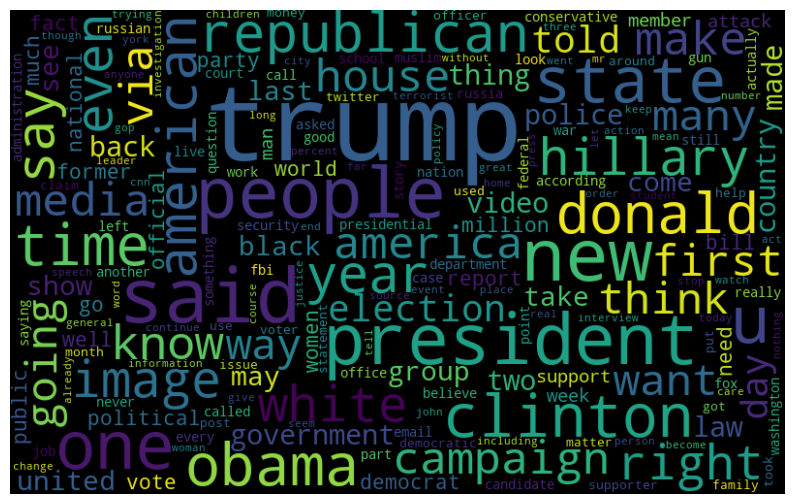

In [22]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

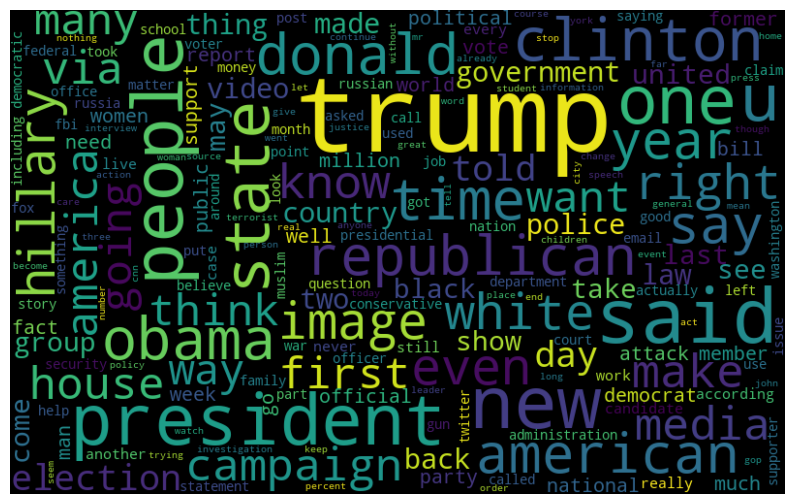

In [23]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

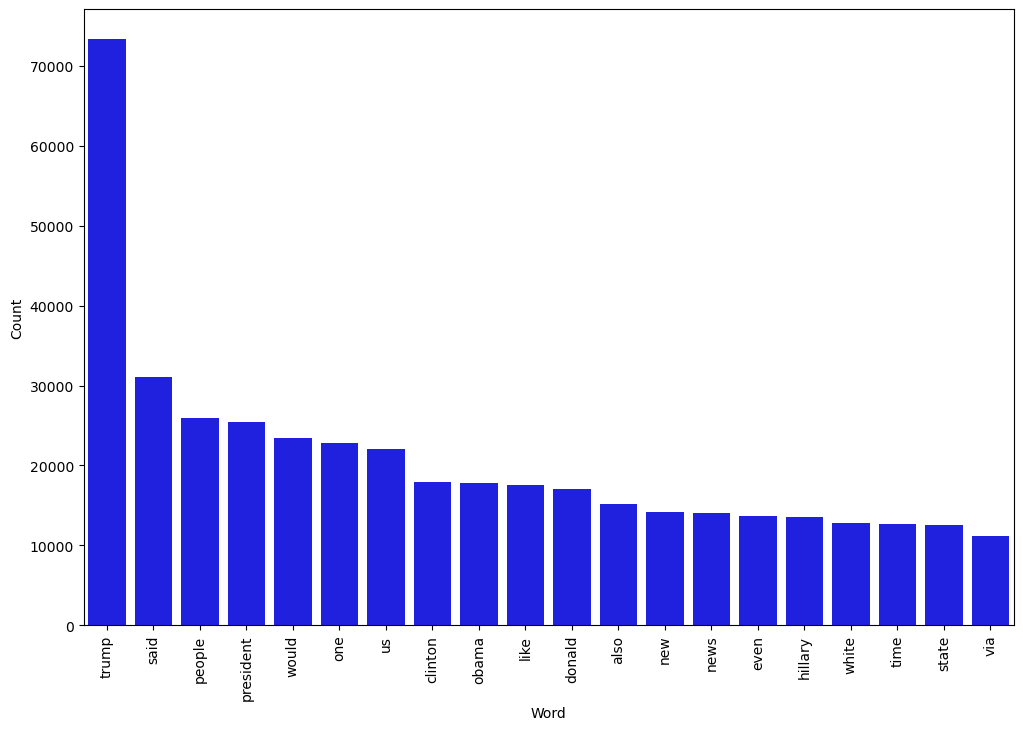

In [25]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

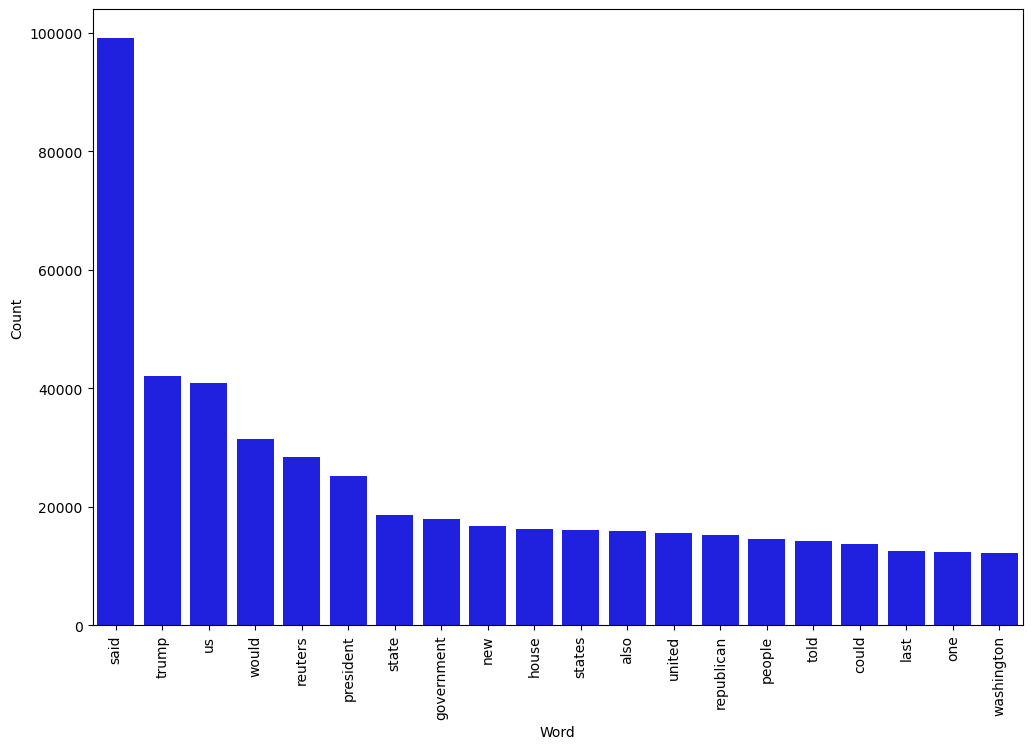

In [26]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [27]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [28]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [29]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 94.88%


Confusion matrix, without normalization


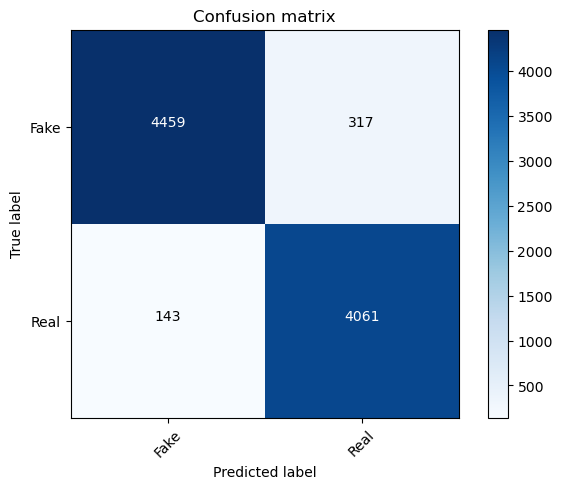

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Logistic regression**

In [31]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.92%


Confusion matrix, without normalization


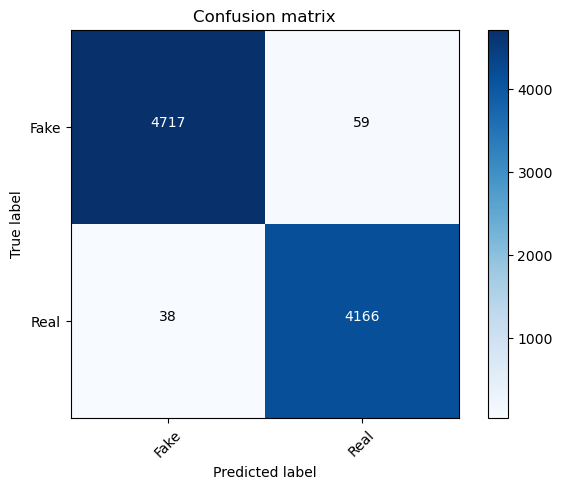

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Decision Tree**

In [33]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.61%


Confusion matrix, without normalization


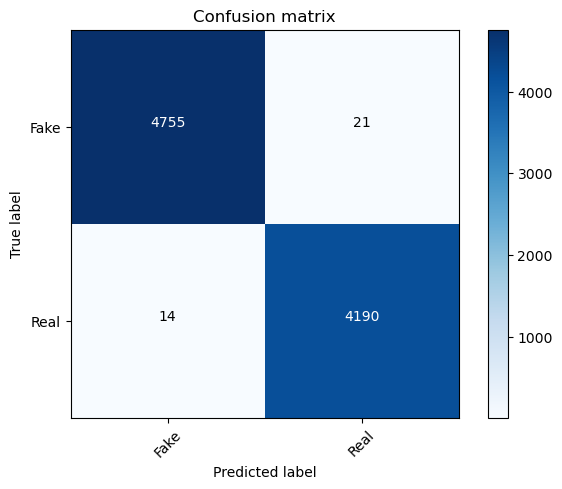

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest**

In [35]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.01%


Confusion matrix, without normalization


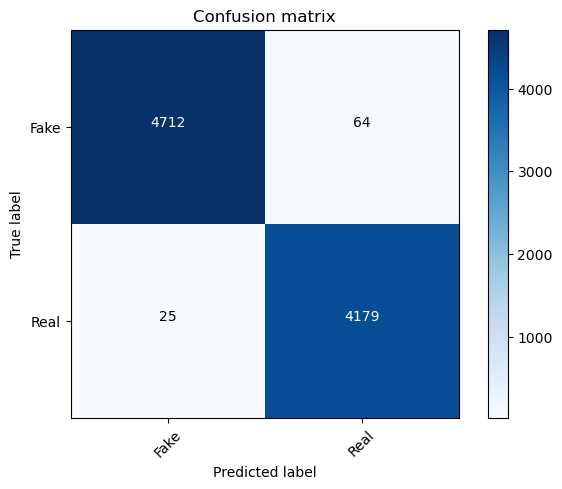

In [36]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM**

In [37]:
'''from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)
'''


'from sklearn import svm\n\n#Create a svm Classifier\nclf = svm.SVC(kernel=\'linear\') # Linear Kernel\n\npipe = Pipeline([(\'vect\', CountVectorizer()),\n                 (\'tfidf\', TfidfTransformer()),\n                 (\'model\', clf)])\n\nmodel = pipe.fit(X_train, y_train)\nprediction = model.predict(X_test)\nprint("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))\ndct[\'SVM\'] = round(accuracy_score(y_test, prediction)*100,2)\n'

In [38]:
'''cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])'''

"cm = metrics.confusion_matrix(y_test, prediction)\nplot_confusion_matrix(cm, classes=['Fake', 'Real'])"

# **Comparing** **Different Models**

([<matplotlib.axis.YTick at 0x2dd083f1350>,
 [Text(0, 91, '91'),
  Text(0, 92, '92'),
  Text(0, 93, '93'),
  Text(0, 94, '94'),
  Text(0, 95, '95'),
  Text(0, 96, '96'),
  Text(0, 97, '97'),
  Text(0, 98, '98'),
  Text(0, 99, '99'),
  Text(0, 100, '100')])

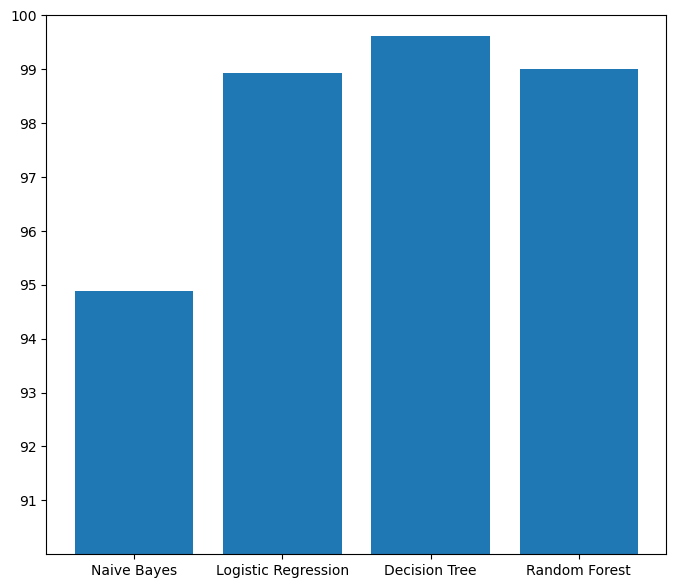

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))